## The purpose of the Capstone 2 project is to determine whether or not the lesion in an image is malignant or not 

In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from numpy import array, newaxis, expand_dims

Using TensorFlow backend.
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/seo/environments/my_env/lib/p

In [2]:
%run functions.py

In [3]:
image_path='./Data/Images/'
meta_path='./Data/Descriptions/'

imagelist=os.listdir(image_path)
metalist=os.listdir(meta_path)

pics=[file for file in imagelist]
meta=[file for file in metalist]

process_path='./'
processfiles=os.listdir(process_path)

In [4]:
import pickle
model=pickle.load(open('model_fitted.pickle',"rb"))

W1012 18:55:47.844865 140085265340224 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1012 18:55:47.893771 140085265340224 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1012 18:55:47.942685 140085265340224 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1012 18:55:47.943993 140085265340224 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated

In [5]:
# Set some parameters
im_width = 128
im_height = 128
img_channels=3
images = np.zeros((len(pics),im_height, im_width, 1), dtype=np.float32)

test_img=call_image(test)
test2=resize(test_img, (128, 128, 1), mode = 'constant', 
                  preserve_range = True)
imshow(array_resize(test_img).squeeze())
imshow(test2.squeeze())

for every picture
call image
denoise
resize
apply mask to get only lesion
have label as dictionary key
save every 1999 pictures

In [6]:
from PIL import Image
i=0
resized_dict=dict()
orig_resized=dict()
for pic_name in pics:
    name=image_path+pic_name
    label=pic_name.split('.')[0]
    tag0='orig'
    tag1="resized"
    img=call_image(name)
    orig_img=Image.open(name)
    orig_resized[label]=orig_img.resize((im_width,im_height))

    denoised_img=denoise(img)
    resized=array_resize(denoised_img)
    resized_dict[label]=resized
    if len(resized_dict)%1999==0:
        i+=1
        print(i)
        save_name0='{}_{}.p'.format(tag0,i)
        save_name1='{}_{}.p'.format(tag1,i)
        pickle.dump(orig_resized, open(save_name0,"wb"))
        pickle.dump(resized_dict, open(save_name1,"wb"))
        del resized_dict
        del orig_resized
        resized_dict=dict()
        orig_resized=dict()
        
resized_files=[file for file in processfiles if file.split('_')[0]==tag1]
orig_resized_files=[file for file in processfiles if file.split('_')[0]==tag0]

As we will be working a lot with pickled data, a function was created to load all the partly saved pickled files

In [5]:
import pickle
def load_all_pickles(tag_name, path ,delimiter):
    processfiles=os.listdir(path)
    agg_dict=dict()
    tagged_files=[file for file in processfiles if file.split(delimiter)[0]==tag_name]
    for file in tagged_files:
        open_file=pickle.load(open(file,'rb'))
        agg_dict.update(open_file)
    return agg_dict

In [12]:
resized=load_all_pickles('resized',process_path,'_')

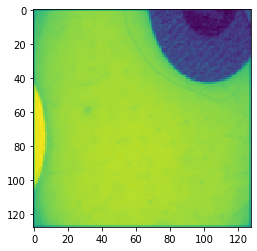

In [23]:
plt.imshow(resized['ISIC_0003525'].squeeze())

In [9]:
i=0
pred_dict=dict()
for key in resized.keys():
    tag2="pred"
    img=resized[key]
    _,pred = prediction(model,img)
    mask=mask_w_predicted(pred)
    pred_dict[key]=mask
    if len(pred_dict)%1999==0:
        i+=1
        save_name2='{}_{}.p'.format(tag2,i)
        pickle.dump(pred_dict, open(save_name2,"wb"))
        del pred_dict
        pred_dict=dict()
pred_files=[file for file in processfiles if file.split('_')[0]==tag2]

In [14]:
pred=load_all_pickles('pred',process_path,'_')

In [15]:
len(pred)

21989

Using the mask obtained by the UNET model, the images were segmented and the contour were identified.

In [ ]:
i=0
cont_dict=dict()
seg_dict=dict()
for key in pred.keys():
    tag3="semmm"
    tag4="connnn"
    mask=pred[key]
    try:
        cnts,h=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE )
        contour=cnts[0]
    except:
        continue
    try:
        M = cv2.moments(contour)
        (a,b),(MA,ma),angle = cv2.fitEllipse(contour)
    except:
        continue
    cont_dict[key]=[cnts[0],angle,int(a),int(b)]    

    try:
        orig_img=call_image(image_path+key+'.jpeg')
        resized_orig=resize(orig_img, (128, 128, 1), mode = 'constant', 
                            preserve_range = True)
        dst = cv2.bitwise_and(resized_orig, resized_orig, mask=mask)
    except:
        continue
    seg_dict[key]=dst
    if len(cont_dict)%1999==0:
        i+=1
        save_name3='{}_{}.p'.format(tag3,i)
        save_name4='{}_{}.p'.format(tag4,i)
        pickle.dump(seg_dict, open(save_name3,"wb"))
        pickle.dump(cont_dict, open(save_name4,"wb"))
        del cont_dict
        del seg_dict
        cont_dict=dict()
        seg_dict=dict()
